Wczytanie danych

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

## Informacje o datasecie

In [3]:
with open('mammographic_masses.names') as f:
    print(f.read())

1. Title: Mammographic Mass Data

2. Sources:

   (a) Original owners of database:
        Prof. Dr. Rüdiger Schulz-Wendtland
        Institute of Radiology, Gynaecological Radiology, University Erlangen-Nuremberg
        Universitätsstraße 21-23
        91054 Erlangen, Germany
        
   (b) Donor of database:
        Matthias Elter
        Fraunhofer Institute for Integrated Circuits (IIS)
        Image Processing and Medical Engineering Department (BMT) 
        Am Wolfsmantel 33
        91058 Erlangen, Germany
        matthias.elter@iis.fraunhofer.de
        (49) 9131-7767327 
        
   (c) Date received: October 2007
 
3. Past Usage:
    M. Elter, R. Schulz-Wendtland and T. Wittenberg (2007)
    The prediction of breast cancer biopsy outcomes using two CAD approaches that both emphasize an intelligible decision process.
    Medical Physics 34(11), pp. 4164-4172

4. Relevant Information:
    Mammography is the most effective method for breast cancer screening
    available today

## Czyszczenie datasetu, stadaryzacja, dekodowanie etykiet na wartości binarne

In [4]:
data = pd.read_csv('mammographic_masses.data', header=None)
data.head()

,0,1,2,3,4,5
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


In [5]:
data = data.rename(columns={0: 'BI-RADS assessment', 1 : 'Age', 2 : 'Shape', 3 : 'Margin', 4 : 'Density', 5 : 'Severity'})

In [6]:
data.head()

,BI-RADS assessment,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


Sprawdzenie czy są brakujące dane

In [7]:
print(data.isnull().values.any())

False


Widać że niektóre wartości są pouzupełniane stringami, mimo że wyszukanie pustych komórek zwraca false.
Puste wartości są stringami w postaci '?'

In [8]:
print("Liczba wartosci {} wynosi {}".format('?',np.count_nonzero(data.values == '?')))

Liczba wartosci ? wynosi 162


Usunięcie wszystkich wartości gdzie jest "?"

In [9]:
for column in data.columns:
    to_mean_calc = np.array(data.loc[data[column] != '?', column])
    to_mean_calc = to_mean_calc.astype('int32')
    data.loc[data[column] == '?', column] = np.mean(to_mean_calc).astype('int32')

print("Liczba wartosci {} wynosi {}".format('?',np.count_nonzero(data.values == '?')))

Liczba wartosci ? wynosi 0


BI-RADS jest zmienną która wg opisu datasetu nie będzie używana do predykcji, stąd kolumnę można usunąć,
Stworzymy nowy dataframe na dane do przetwarzania.

In [10]:
dataset = data.copy()
dataset.drop('BI-RADS assessment', axis='columns', inplace = True)
dataset.head()

,Age,Shape,Margin,Density,Severity
0,67,3,5,3,1
1,43,1,1,2,1
2,58,4,5,3,1
3,28,1,1,3,0
4,74,1,5,2,1


Wszystkie dane są danymi kategorycznymi, stąd też zrzutujemy wszystkie tabele do inta, żeby zachować wartości klas

In [11]:
dataset = dataset.astype('int64')
dataset.dtypes

Age         int64
Shape       int64
Margin      int64
Density     int64
Severity    int64
dtype: object

Z racji zastosowania danych kategorycznych, zastosujemy OneHotEncoding tych danych

Tabela Age zostanie znormalizowana z uzyciem StandardScalera 
>Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)

>Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)

>Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)

>Age: int, należy znormalizować

In [12]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
scaler = StandardScaler()
dataset['Age'] = scaler.fit_transform(np.asarray(dataset['Age']).reshape(-1,1))
dataset.head()

,Age,Shape,Margin,Density,Severity
0,0.797726,3,5,3,1
1,-0.864912,1,1,2,1
2,0.174237,4,5,3,1
3,-1.904060,1,1,3,0
4,1.282661,1,5,2,1


In [13]:
dataset = pd.get_dummies(dataset, columns=['Shape'])
dataset.head()

,Age,Margin,Density,Severity,Shape_1,Shape_2,Shape_3,Shape_4
0,0.797726,5,3,1,0,0,1,0
1,-0.864912,1,2,1,1,0,0,0
2,0.174237,5,3,1,0,0,0,1
3,-1.904060,1,3,0,1,0,0,0
4,1.282661,5,2,1,1,0,0,0


In [14]:
dataset = pd.get_dummies(dataset, columns=['Margin'])
dataset.head()

,Age,Density,Severity,Shape_1,Shape_2,Shape_3,Shape_4,Margin_1,Margin_2,Margin_3,Margin_4,Margin_5
0,0.797726,3,1,0,0,1,0,0,0,0,0,1
1,-0.864912,2,1,1,0,0,0,1,0,0,0,0
2,0.174237,3,1,0,0,0,1,0,0,0,0,1
3,-1.904060,3,0,1,0,0,0,1,0,0,0,0
4,1.282661,2,1,1,0,0,0,0,0,0,0,1


In [15]:
dataset = pd.get_dummies(dataset, columns=['Density'])
dataset.head()

,Age,Severity,Shape_1,Shape_2,Shape_3,Shape_4,Margin_1,Margin_2,Margin_3,Margin_4,Margin_5,Density_1,Density_2,Density_3,Density_4
0,0.797726,1,0,0,1,0,0,0,0,0,1,0,0,1,0
1,-0.864912,1,1,0,0,0,1,0,0,0,0,0,1,0,0
2,0.174237,1,0,0,0,1,0,0,0,0,1,0,0,1,0
3,-1.904060,0,1,0,0,0,1,0,0,0,0,0,0,1,0
4,1.282661,1,1,0,0,0,0,0,0,0,1,0,1,0,0


Każda ostatnia wartość cech kodowanych binarnie jest nadmiarowa, zatem można ją usunąć

Przykład z Shape:

| Shape_1 | Shape_2 | Shape_3 | Shape_4 |
|---------|---------|---------|---------|
|   0     | 0       | 0       | 1       |



Jest tym samy co:

| Shape_1 | Shape_2 | Shape_3 |
|---------|---------|---------|
| 0       | 0       | 0       |



Dlatego mozna usunąć każdą ostatnią cechę


In [16]:
dataset = dataset[['Age', 'Shape_1', 'Shape_2', 'Shape_3', 'Margin_1', 'Margin_2', 'Margin_3', 'Margin_4',
                        'Density_1', 'Density_2', 'Density_3', 'Severity']]
dataset.head()

,Age,Shape_1,Shape_2,Shape_3,Margin_1,Margin_2,Margin_3,Margin_4,Density_1,Density_2,Density_3,Severity
0,0.797726,0,0,1,0,0,0,0,0,0,1,1
1,-0.864912,1,0,0,1,0,0,0,0,1,0,1
2,0.174237,0,0,0,0,0,0,0,0,0,1,1
3,-1.904060,1,0,0,1,0,0,0,0,0,1,0
4,1.282661,1,0,0,0,0,0,0,0,1,0,1


## Rozkład poszczególnych badanych parametrów z datasetu

> ile osób w jakim wieku?

> Średnia wieku, mediana, drugi moment statytyczny

>> Poszczególne wartości 1,2,3,4 należy odkodować za pomocą etykiet z opisu datasetu (nie dotyczy histogramu dla wieku osób)

Średnia wieku to: 55 lat


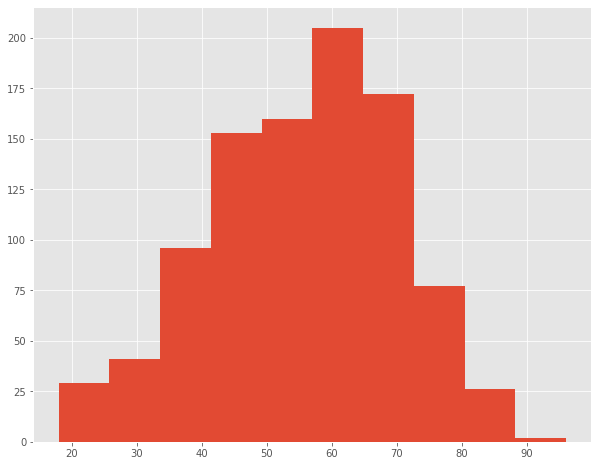

In [17]:
data = data.astype('int64')
age_of_people = np.array(data.iloc[:,1].values)
data['Age'].hist(figsize=(10,8))
print("Średnia wieku to: {:.0f} lat".format(age_of_people.mean()))

Opis danych za pomocą describe

In [18]:
data.describe()

,BI-RADS assessment,Age,Shape,Margin,Density,Severity
count,961.000000,961.000000,961.000000,961.000000,961.00000,961.000000
mean,4.347555,55.484912,2.698231,2.756504,2.83871,0.463059
std,1.781244,14.442416,1.229196,1.536711,0.44017,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.00000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.00000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.00000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.00000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.00000,1.000000


Rozkład wartości shape na historgramie

<AxesSubplot:>

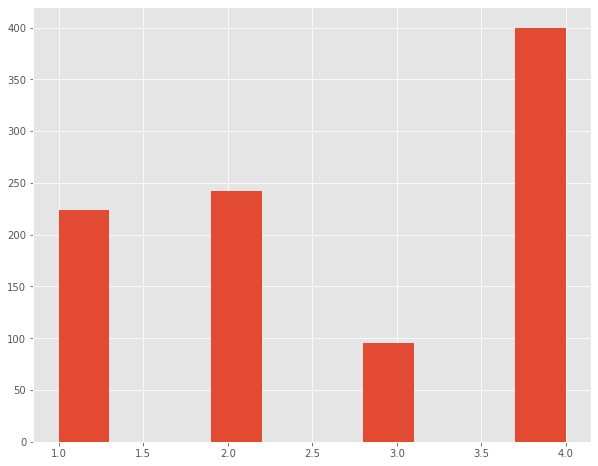

In [19]:
data['Shape'].hist(figsize=(10,8))


Rozkład parametru margin

<AxesSubplot:>

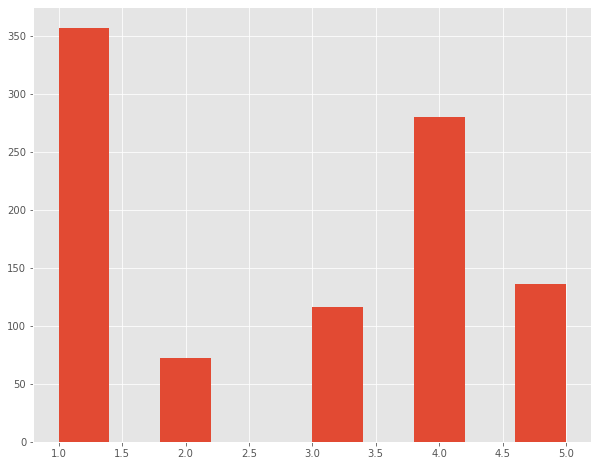

In [20]:
data['Margin'].hist(figsize=(10,8))

Rozkład parametru density

<AxesSubplot:>

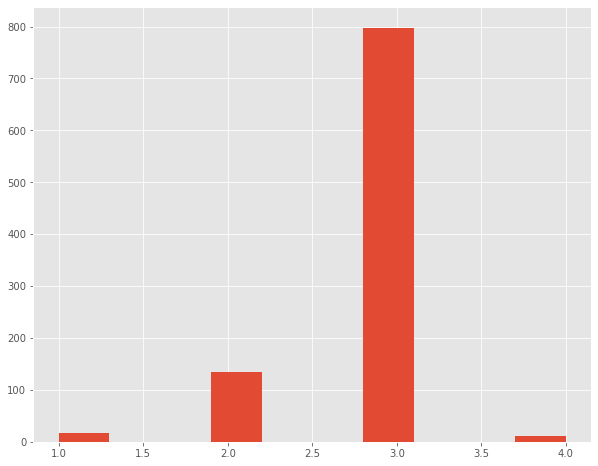

In [21]:
data['Density'].hist(figsize=(10,8))

Wykres współrzędnych równoległych (ang. *parallel coordinates plot*), który polega na przedstawieniu wszystkich wymiarów przetwarzanego zbioru danych w postaci pionowych osi liczbowych. Następnie każdy punkt na takim zestawie osi przedstawiany jest w postaci łamanej, która składa się z wartości danego punktu danych przypisanych do każdej z osi. 